<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Abschnitt_7_Food_vision_blog/07_milestone_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

## Check GPU

* Google Colab offers free GPUs, however, not all of them ar compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we´re using our own hardware, our GPU need a score of 7.0+.

In [10]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d23e8c6f-3eb9-c148-5793-483ac6eb5a1a)


## Get helper functions

In [5]:
# Download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-02 06:32:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-02 06:32:17 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download Data

In [8]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [9]:
# List all available datasets
datasets_list = tfds.list_builders() #get all available datasets in TFDS
print("food101" in datasets_list)

True


In [11]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True, #gets data returned in tuple format (data, label)
                                             with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompletePPZOXL/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompletePPZOXL/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

We want to find:
* Class names
* Shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (one hot hot encoded or label encoded?)
* Do the labels match up with the class names?


In [12]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [13]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [23]:
# Take one sample of the train data
train_one_sample = train_data.take(1) #samples are in format (image_tensor, label)

In [24]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [25]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor format): {label}
  Class name (str format): {class_names[label.numpy()]}
  """)


  Image shape: (512, 289, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor format): 45
  Class name (str format): frozen_yogurt
  


In [26]:
# What does our image tensor from TFDS´s Food 101 look like?
image

<tf.Tensor: shape=(512, 289, 3), dtype=uint8, numpy=
array([[[145, 151, 125],
        [157, 163, 137],
        [159, 165, 139],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [197, 207, 198]],

       [[146, 152, 126],
        [156, 162, 136],
        [158, 164, 138],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 200]],

       [[150, 156, 130],
        [155, 161, 135],
        [157, 163, 137],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 198]],

       ...,

       [[173, 186, 177],
        [174, 187, 178],
        [176, 189, 180],
        ...,
        [181, 197, 187],
        [181, 197, 187],
        [178, 195, 187]],

       [[176, 187, 179],
        [176, 187, 179],
        [176, 189, 180],
        ...,
        [182, 198, 188],
        [182, 198, 188],
        [180, 197, 189]],

       [[178, 189, 181],
        [177, 188, 180],
        [175, 188, 179],
        ...,
        [179, 195, 18

In [27]:
#What are the min and max values of our image tensors?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow dataset

(-0.5, 288.5, 511.5, -0.5)

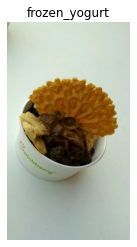

In [28]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) #Add title to image
plt.axis(False)

## Create preprocessing functions for our data

NN perform best when data is in a certain way (e.g. batched, normalized, etc.)

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you´ll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In uint8 dtype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixels values are between 0&255)

What we know models like:
* Data in float32 dtype (or for mixed precision float16 and float32)
* For batches, TensorFlow likes all of the tensors within a batch to be the same size
* Scaled (values between 0 & 1) also calles normalized tensors generally performs better

With these points in mind, we´ve got a few things we can tackle with a preprocessing function.